# Analysis of Spaceship Titanic dataset

We have binary dataset of simulated data. The idea behind the data is transportation of the passangers from the planet Earth to another. Let's see how the data looks like.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,\
ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

import pickle

In [3]:
df_train = pd.read_csv("train.csv")
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df_test = pd.read_csv("test.csv")
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
print(df_train.isna().sum())
df_test.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

We have around 200 observation with missing values in training dataset and 100 observations in test dataset. Since we have to upload prediction for all passengers drop missing values is not the right case and we will try to generate this values for proper analysis

In [6]:
df_full = pd.concat([df_train, df_test], axis=0)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [7]:
df_full.iloc[8690:8695, :]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,NaN


### We start from analysis of each column and replace missing values

#### Since we will not consider Passenger ID for model simulation which could introduce bias, first column will be Home Planet

In [8]:
df_full["HomePlanet"].value_counts()

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

In [9]:
df_full["HomePlanet"].isna().sum()

288

I lean towards replacements all values with Earth, since majority of the passengers ~60% is from Earth, so on avarage we will be right in 60 % observations. So for 170 observation we have a good data and rest 100 will not have large impact on data compare to 12K observations

In [10]:
df_full.loc[df_full["HomePlanet"].isna(), "HomePlanet"] = "Earth"
df_full["HomePlanet"].value_counts()

Earth     7153
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

### For the second column we examine CryoSleep as False and True value and later convert it to 1 and 0 values

In [11]:
df_full["CryoSleep"].value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [12]:
df_full["CryoSleep"].isna().sum()

310

In this case we replace missing data with False as for 65% of the data it will be right approach and for rest 140 missrepresented value will not probably have large imapact 

In [13]:
df_full.loc[df_full["CryoSleep"].isna(), "CryoSleep"] = False
df_full["CryoSleep"] = df_full["CryoSleep"].astype(int)
df_full["CryoSleep"].value_counts()

0    8389
1    4581
Name: CryoSleep, dtype: int64

### Column Cabin as itself does not provide much of the information, so we separate this into columns Deck and Side. 

Number of the room is not well understood since have many 0's and 1's which can be misrepresented by model. So we create new columns and drop Cabin. Later we examine each of newly created 

In [14]:
df_full.loc[df_full["Cabin"].isna(), "Cabin"] = "F/JD/S"

In [15]:
df_full["Deck"] = df_full["Cabin"].apply(lambda x: str(x).split("/")[0])
df_full["Deck"].value_counts()

F    4538
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Deck, dtype: int64

In [16]:
def find_value(row):
    try:
        return str(row).split("/")[2]
    except IndexError:
        return None

df_full["Side"] = df_full["Cabin"].apply(find_value)    
df_full["Side"].value_counts()

S    6680
P    6290
Name: Side, dtype: int64

In [17]:
df_full["Side"].isna().sum()

0

I replaced Deck with F value and Side with S as most common and for majority will be correct. Another approach would be just drop values in training set and replace values in test.

In [18]:
df_full = df_full.drop(columns="Cabin", axis=1)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P
1,0002_01,Earth,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S
2,0003_01,Europa,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S
3,0003_02,Europa,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S
4,0004_01,Earth,0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S


#### Next column will be Destination. 

In [19]:
df_full["Destination"].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [20]:
df_full["Destination"].isna().sum()

274

We have majority who is moving to the planet Trappist and 70% we have a good chance for replacing missing values for this planet. Later we will use dummy variables to trasform this column. 

In [21]:
df_full.loc[df_full["Destination"].isna(), "Destination"] = "TRAPPIST-1e"
df_full["Destination"].value_counts()

TRAPPIST-1e      9145
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [22]:
df_full["Destination"] = df_full["Destination"].replace("TRAPPIST-1e", "TRAPPIST").replace("55 Cancri e", "Cancri").replace("PSO J318.5-22", "PSO")
df_full["Destination"].value_counts()

TRAPPIST    9145
Cancri      2641
PSO         1184
Name: Destination, dtype: int64

#### Next column age. For this case we use avarage age for the population.

In [23]:
df_full["Age"].describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [24]:
df_full["Age"].isna().sum()

270

In [25]:
df_full.loc[df_full["Age"].isna(), "Age"] = 28
df_full.describe()

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12970.000000,12970.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,0.353200,28.755898,222.897852,451.961675,174.906033,308.476904,306.789482
std,0.477983,14.237137,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,37.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,1.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


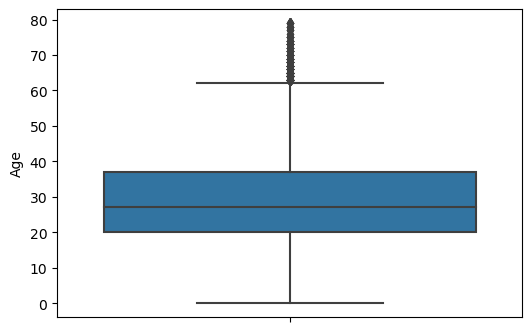

In [26]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["Age"])

plt.ylabel("Age")  

plt.show()

In [27]:
percentile25 = df_full["Age"].quantile(0.25)
percentile75 = df_full["Age"].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit", upper_limit)
print("Lower limit", lower_limit)

outlier_age = df_full[(df_full["Age"] > upper_limit) | (df_full["Age"] < lower_limit)]

print("Number of outliers in the Age section", len(outlier_age))
print(1.5 * iqr)

Upper limit 62.5
Lower limit -5.5
Number of outliers in the Age section 237
25.5


We replaced missing values from dataset by average age of the population. Also notible that Age has outliers (237) which could affect some models like Logistic Regression and Naive Bayes. For Random Forest it will affect only in extreme cases, so we stick with this and correct in case of nessacity.

### Next we explore VIP

In [28]:
df_full["VIP"].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [29]:
df_full["VIP"].isna().sum()

296

In [30]:
df_full.loc[df_full["VIP"].isna(), "VIP"] = False
df_full["VIP"] = df_full["VIP"].astype(int)
df_full["VIP"].value_counts()

0    12697
1      273
Name: VIP, dtype: int64

In [31]:
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S


### Room Service, Food Court, Shopping Mall, Spa, VR Deck

All these columns have consecutive values and we replace missing values with median value in each column

In [32]:
df_full["RoomService"].describe()

count    12707.000000
mean       222.897852
std        647.596664
min          0.000000
25%          0.000000
50%          0.000000
75%         49.000000
max      14327.000000
Name: RoomService, dtype: float64

In [33]:
df_full["RoomService"].isna().sum()

263

In [34]:
df_full["RoomService"].median()

0.0

In [35]:
df_full.loc[df_full["RoomService"].isna(), "RoomService"] = 0.0
df_full["RoomService"].isna().sum()

0

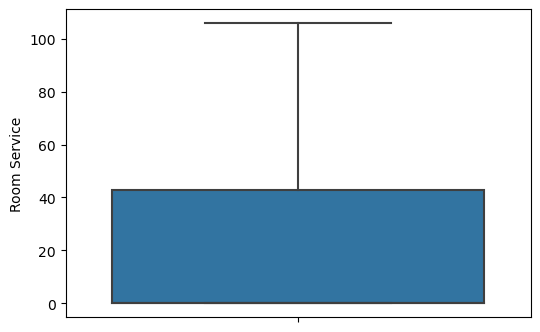

In [36]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["RoomService"], showfliers=False)

plt.ylabel("Room Service")  

plt.show()

As we can see majority of the values are outliers and most probably it is introduce large bias

In [37]:
df_full["FoodCourt"].describe()

count    12681.000000
mean       451.961675
std       1584.370747
min          0.000000
25%          0.000000
50%          0.000000
75%         77.000000
max      29813.000000
Name: FoodCourt, dtype: float64

In [38]:
df_full["FoodCourt"].isna().sum()

289

In [39]:
df_full["FoodCourt"].median()

0.0

In [40]:
df_full.loc[df_full["FoodCourt"].isna(), "FoodCourt"] = 0.0

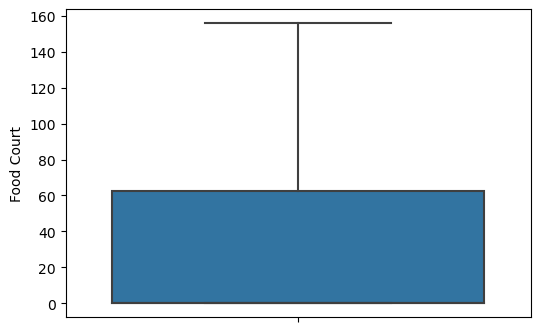

In [41]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["FoodCourt"], showfliers=False)

plt.ylabel("Food Court")  

plt.show()

Similar case for Food Court

In [42]:
df_full["ShoppingMall"].describe()

count    12664.000000
mean       174.906033
std        590.558690
min          0.000000
25%          0.000000
50%          0.000000
75%         29.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [43]:
df_full["ShoppingMall"].isna().sum()

306

In [44]:
df_full.loc[df_full["ShoppingMall"].isna(), "ShoppingMall"] = 0.0
df_full["ShoppingMall"].isna().sum()

0

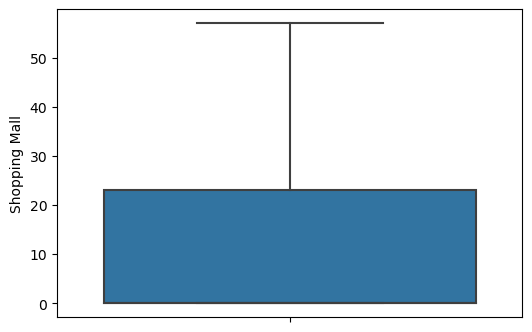

In [45]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["ShoppingMall"], showfliers=False)

plt.ylabel("Shopping Mall")  

plt.show()

In [46]:
df_full["Spa"].describe()

count    12686.000000
mean       308.476904
std       1130.279641
min          0.000000
25%          0.000000
50%          0.000000
75%         57.000000
max      22408.000000
Name: Spa, dtype: float64

In [47]:
df_full["Spa"].isna().sum()

284

In [48]:
df_full.loc[df_full["Spa"].isna(), "Spa"] = 0.0
df_full["Spa"].isna().sum()

0

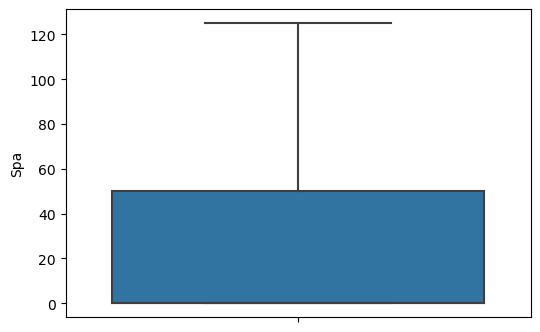

In [49]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["Spa"], showfliers=False)

plt.ylabel("Spa")  

plt.show()

In [50]:
df_full["VRDeck"].describe()

count    12702.000000
mean       306.789482
std       1180.097223
min          0.000000
25%          0.000000
50%          0.000000
75%         42.000000
max      24133.000000
Name: VRDeck, dtype: float64

In [51]:
df_full.loc[df_full["VRDeck"].isna(), "VRDeck"] = 0.0
df_full["VRDeck"].isna().sum()

0

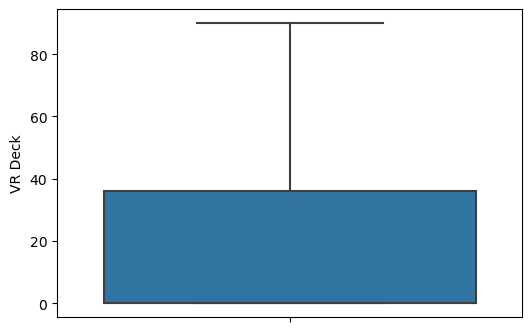

In [52]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["VRDeck"], showfliers=False)

plt.ylabel("VR Deck")  

plt.show()

As we can see every of this column has extensive outliers which can affect our model prediction. We can make one column as TotalSpend

In [53]:
df_full["TotalSpend"] = (
    df_full["RoomService"] + 
    df_full["FoodCourt"] + 
    df_full["ShoppingMall"] + 
    df_full["Spa"] + 
    df_full["VRDeck"]
)
df_full["TotalSpend"].describe()

count    12970.000000
mean      1433.221049
std       2807.369708
min          0.000000
25%          0.000000
50%        716.000000
75%       1442.000000
max      35987.000000
Name: TotalSpend, dtype: float64

In [54]:
df_full["TotalSpend"].isna().sum()

0

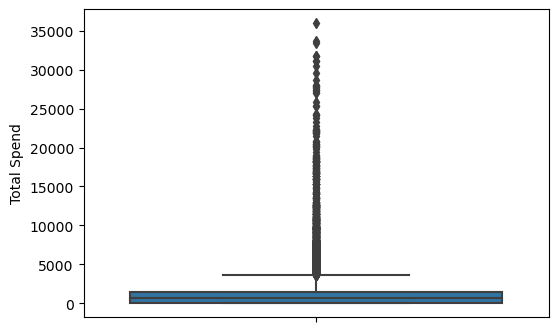

In [55]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["TotalSpend"], showfliers=True)

plt.ylabel("Total Spend")  

plt.show()

In [56]:
zeros_TotalSpend = df_full[df_full["TotalSpend"] == 0.0]
print("Number of obs that have 0 spend", len(zeros_TotalSpend))

Number of obs that have 0 spend 5457


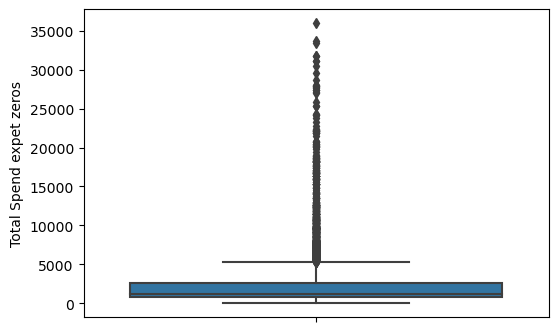

In [57]:
not_zeros = df_full[df_full["TotalSpend"] > 0]
plt.figure(figsize=(6, 4))  
sns.boxplot(y = not_zeros["TotalSpend"], showfliers=True)

plt.ylabel("Total Spend expet zeros")  

plt.show()

##### I have decided to create two new column people who spend and who's not as 0/1, and also Rich as to describe outliers in this data and rest of the column just drop.

In [58]:
df_full["Spend"] = df_full["TotalSpend"].apply(lambda x: False if x == 0.0 else True)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,TotalSpend,Spend
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0.0,False
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,736.0,True
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,10383.0,True
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,5176.0,True
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,1091.0,True


In [59]:
df_full["Spend"] = df_full["Spend"].astype(int)
df_full["Spend"].value_counts()

1    7513
0    5457
Name: Spend, dtype: int64

In [60]:
percentile25 = df_full["TotalSpend"].quantile(0.25)
percentile75 = df_full["TotalSpend"].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit", upper_limit)
print("Lower limit", lower_limit)

outlier_total_spend = df_full[(df_full["TotalSpend"] > upper_limit) | (df_full["TotalSpend"] < lower_limit)]

print("Number of outliers in the TotalSpend section", len(outlier_total_spend))

Upper limit 3605.0
Lower limit -2163.0
Number of outliers in the TotalSpend section 1357


We will identify Rich people as someone who spend more 3605 over the trip on accomodation.

In [61]:
df_full["Rich"] = df_full["TotalSpend"].apply(lambda x: True if x >= 3605 else False)
df_full["Rich"] = df_full["Rich"].astype(int)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,TotalSpend,Spend,Rich
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0.0,0,0
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,736.0,1,0
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,10383.0,1,1
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,5176.0,1,1
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,1091.0,1,0


Now we can drop columns room service, food court, shopping mall, spa, vr deck and total spend

In [62]:
df_full = df_full.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpend"], axis=1)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Name,Transported,Deck,Side,Spend,Rich
0,0001_01,Europa,0,TRAPPIST,39.0,0,Maham Ofracculy,False,B,P,0,0
1,0002_01,Earth,0,TRAPPIST,24.0,0,Juanna Vines,True,F,S,1,0
2,0003_01,Europa,0,TRAPPIST,58.0,1,Altark Susent,False,A,S,1,1
3,0003_02,Europa,0,TRAPPIST,33.0,0,Solam Susent,False,A,S,1,1
4,0004_01,Earth,0,TRAPPIST,16.0,0,Willy Santantines,True,F,S,1,0


#### Usualy name does not provide much of useful information, so we drop this column together with passenger id

In [63]:
df_full = df_full.drop(columns=["PassengerId", "Name"], axis=1)
df_full.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Deck,Side,Spend,Rich
0,Europa,0,TRAPPIST,39.0,0,False,B,P,0,0
1,Earth,0,TRAPPIST,24.0,0,True,F,S,1,0
2,Europa,0,TRAPPIST,58.0,1,False,A,S,1,1
3,Europa,0,TRAPPIST,33.0,0,False,A,S,1,1
4,Earth,0,TRAPPIST,16.0,0,True,F,S,1,0


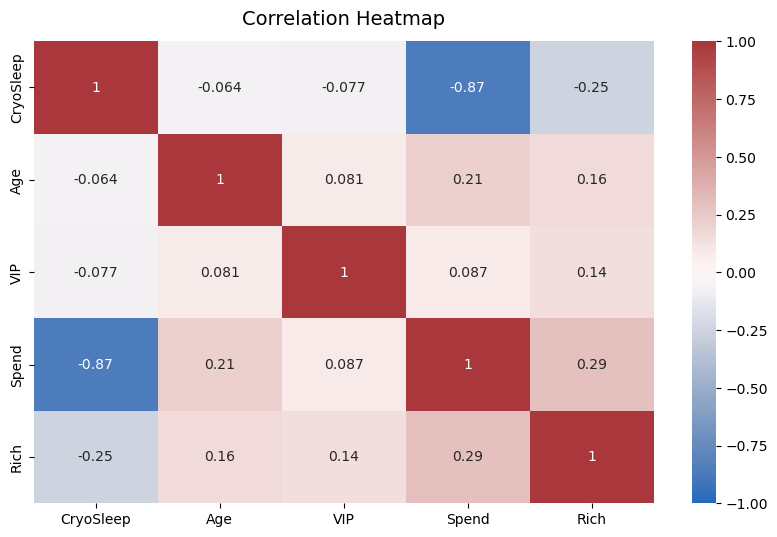

In [64]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_full.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

#### We observe strong anticorrelation between people who sleep and who spend. As we can see people not going to cryosleep as they spend

### Only categorical data left, so we apply dummy encoding to columns Home planet, Destination, Deck and Side

In [65]:
df_full_enc = pd.get_dummies(df_full, columns=["HomePlanet", "Destination", "Deck", "Side"], drop_first=False)
df_full_enc.head()

,CryoSleep,Age,VIP,Transported,Spend,Rich,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_Cancri,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0,False,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,True,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,False,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,False,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,True,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [66]:
df_full_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             12970 non-null  int64  
 1   Age                   12970 non-null  float64
 2   VIP                   12970 non-null  int64  
 3   Transported           8693 non-null   object 
 4   Spend                 12970 non-null  int64  
 5   Rich                  12970 non-null  int64  
 6   HomePlanet_Earth      12970 non-null  uint8  
 7   HomePlanet_Europa     12970 non-null  uint8  
 8   HomePlanet_Mars       12970 non-null  uint8  
 9   Destination_Cancri    12970 non-null  uint8  
 10  Destination_PSO       12970 non-null  uint8  
 11  Destination_TRAPPIST  12970 non-null  uint8  
 12  Deck_A                12970 non-null  uint8  
 13  Deck_B                12970 non-null  uint8  
 14  Deck_C                12970 non-null  uint8  
 15  Deck_D              

Now it is time to separate the test data from train data. Also transform the column Transported into binary.

In [67]:
df_full.iloc[8690:8695, :]

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Deck,Side,Spend,Rich
8690,Earth,0,TRAPPIST,26.0,0,True,G,S,1,0
8691,Europa,0,Cancri,32.0,0,False,E,S,1,1
8692,Europa,0,TRAPPIST,44.0,0,True,E,S,1,1
0,Earth,1,TRAPPIST,27.0,0,NaN,G,S,0,0
1,Earth,0,TRAPPIST,19.0,0,NaN,F,S,1,0


In [68]:
df_train_corr = df_full_enc.iloc[:8693, :]
df_test_corr = df_full_enc.iloc[8693:, :]
df_test_corr.head()

,CryoSleep,Age,VIP,Transported,Spend,Rich,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_Cancri,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,1,27.0,0,NaN,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,19.0,0,NaN,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,1,31.0,0,NaN,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
3,0,38.0,0,NaN,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,20.0,0,NaN,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [69]:
df_train_corr.iloc[8690:8693, :]

,CryoSleep,Age,VIP,Transported,Spend,Rich,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_Cancri,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
8690,0,26.0,0,True,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
8691,0,32.0,0,False,1,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
8692,0,44.0,0,True,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [70]:
df_test_corr = df_test_corr.drop(columns=["Transported"], axis=1)
df_test_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 0 to 4276
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             4277 non-null   int64  
 1   Age                   4277 non-null   float64
 2   VIP                   4277 non-null   int64  
 3   Spend                 4277 non-null   int64  
 4   Rich                  4277 non-null   int64  
 5   HomePlanet_Earth      4277 non-null   uint8  
 6   HomePlanet_Europa     4277 non-null   uint8  
 7   HomePlanet_Mars       4277 non-null   uint8  
 8   Destination_Cancri    4277 non-null   uint8  
 9   Destination_PSO       4277 non-null   uint8  
 10  Destination_TRAPPIST  4277 non-null   uint8  
 11  Deck_A                4277 non-null   uint8  
 12  Deck_B                4277 non-null   uint8  
 13  Deck_C                4277 non-null   uint8  
 14  Deck_D                4277 non-null   uint8  
 15  Deck_E               

In [71]:
df_train_corr["Transported"] = df_train_corr["Transported"].astype(int)
df_train_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             8693 non-null   int64  
 1   Age                   8693 non-null   float64
 2   VIP                   8693 non-null   int64  
 3   Transported           8693 non-null   int64  
 4   Spend                 8693 non-null   int64  
 5   Rich                  8693 non-null   int64  
 6   HomePlanet_Earth      8693 non-null   uint8  
 7   HomePlanet_Europa     8693 non-null   uint8  
 8   HomePlanet_Mars       8693 non-null   uint8  
 9   Destination_Cancri    8693 non-null   uint8  
 10  Destination_PSO       8693 non-null   uint8  
 11  Destination_TRAPPIST  8693 non-null   uint8  
 12  Deck_A                8693 non-null   uint8  
 13  Deck_B                8693 non-null   uint8  
 14  Deck_C                8693 non-null   uint8  
 15  Deck_D               

/var/folders/7m/1c5q60f97cx1t7r9pnhv002c0000gn/T/ipykernel_1164/2224148587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_corr["Transported"] = df_train_corr["Transported"].astype(int)


In [72]:
df_train_corr.head()

,CryoSleep,Age,VIP,Transported,Spend,Rich,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_Cancri,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


# Constuct phase 

In [73]:
X = df_train_corr.drop(columns=["Transported"], axis=1)
y = df_train_corr["Transported"]
X.head()

,CryoSleep,Age,VIP,Spend,Rich,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_Cancri,Destination_PSO,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [74]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 304 to 6093
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             1739 non-null   int64  
 1   Age                   1739 non-null   float64
 2   VIP                   1739 non-null   int64  
 3   Spend                 1739 non-null   int64  
 4   Rich                  1739 non-null   int64  
 5   HomePlanet_Earth      1739 non-null   uint8  
 6   HomePlanet_Europa     1739 non-null   uint8  
 7   HomePlanet_Mars       1739 non-null   uint8  
 8   Destination_Cancri    1739 non-null   uint8  
 9   Destination_PSO       1739 non-null   uint8  
 10  Destination_TRAPPIST  1739 non-null   uint8  
 11  Deck_A                1739 non-null   uint8  
 12  Deck_B                1739 non-null   uint8  
 13  Deck_C                1739 non-null   uint8  
 14  Deck_D                1739 non-null   uint8  
 15  Deck_E             

### First we try to use Logistic Classifier for the analysis

In [75]:
clf_log = LogisticRegression(random_state=42, max_iter=500)

In [76]:
%%time
clf_log.fit(X_train, y_train)

CPU times: user 473 ms, sys: 117 ms, total: 590 ms
Wall time: 78.5 ms


LogisticRegression(max_iter=500, random_state=42)

In [77]:
y_pred_log = clf_log.predict(X_val)

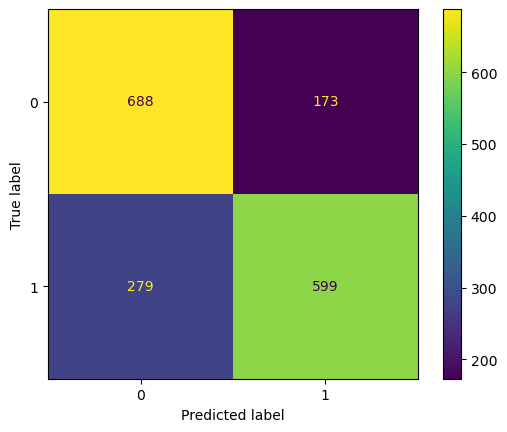

In [78]:
def plot_matrix(model, y_test, y_pred):
    log_cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    # Create display of confusion matrix
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=model.classes_)

    # Plot confusion matrix
    log_disp.plot()

    # Display plot
    plt.show()
    
plot_matrix(clf_log, y_val, y_pred_log)

In [79]:
preds = clf_log.predict(X_val)

auc = round(roc_auc_score(y_val, preds), 3)
accuracy = round(accuracy_score(y_val, preds), 3)
precision = round(precision_score(y_val, preds), 3)
recall = round(recall_score(y_val, preds), 3)
f1 = round(f1_score(y_val, preds), 3)

log_reg_table = pd.DataFrame({'model': "Logistic regression",
                    'AUC': [auc],
                    'precision': [precision], 
                    'recall': [recall],
                    'f1': [f1],
                    'accuracy': [accuracy]
                    })
log_reg_table  

,model,AUC,precision,recall,f1,accuracy
0,Logistic regression,0.741,0.776,0.682,0.726,0.74


This model present not bad results but let's try other options such as Random Forest

### Random Forest Classifier

In [90]:
clf_rf = RandomForestClassifier(random_state=42)

In [91]:
cv_params = {'max_depth': [3,5, None], 
             'max_features': [9,14,22],
             'max_samples': [0.05, 0.1, 0.3],
             'min_samples_leaf': [3, 5, 7],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [100, 300, 500],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(clf_rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [226]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 21min 5s, sys: 8.76 s, total: 21min 14s
Wall time: 52min 55s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [9, 14, 22],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='f1', scoring={'f1', 'precision', 'recall', 'accuracy'})

In [227]:
rf_cv.best_score_

0.7290828165608051

In [228]:
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 9,
 'max_samples': 0.3,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

In [80]:
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
        model_name (string): What you want the model to be called in the output table.
        model_object: A fit GridSearchCV object.
        metric (string): Precision, recall, f1, accuracy, or auc.
  
    Returns a pandas DataFrame with the F1, recall, precision, accuracy, and AUC scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # Get all the results from the CV and put them in a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the DataFrame with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and F1 score from that row
    f1 = best_estimator_results['mean_test_f1']
    recall = best_estimator_results['mean_test_recall']
    precision = best_estimator_results['mean_test_precision']
    accuracy = best_estimator_results['mean_test_accuracy']
  
    # Create DataFrame of results
    table = pd.DataFrame({
        'Model': [model_name],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy
    })
  
    return table

In [230]:
rf_table_f1 = make_results("Random Forest Classifier", rf_cv, "f1")
rf_table_f1

,Model,Precision,Recall,F1,Accuracy
0,Random Forest Classifier,0.799084,0.670571,0.729083,0.749356


In [81]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision], 
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })
  
    return table

In [232]:
rf_score_f1 = get_scores("Random Forest Classifier", rf_cv, X_val, y_val)
rf_score_f1

,model,AUC,precision,recall,f1,accuracy
0,Random Forest Classifier,0.744,0.782,0.68,0.728,0.743


In [92]:
%%time
rf_cv_acc = GridSearchCV(clf_rf, cv_params, scoring=scoring, cv=5, refit='accuracy')
rf_cv_acc.fit(X_train, y_train)

CPU times: user 21min 12s, sys: 9 s, total: 21min 21s
Wall time: 21min 21s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [9, 14, 22],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='accuracy',
             scoring={'accuracy', 'recall', 'precision', 'f1'})

In [93]:
rf_cv_acc.best_score_

0.7532374100719424

In [95]:
rf_table_acc = make_results("Random Forest Classifier accuracy", rf_cv_acc, "accuracy")
rf_table_acc

,Model,Precision,Recall,F1,Accuracy
0,Random Forest Classifier accuracy,0.818466,0.654857,0.727411,0.753237


In [96]:
rf_score_acc = get_scores("Random Forest Classifier accuracy", rf_cv_acc, X_val, y_val)
rf_score_acc

,model,AUC,precision,recall,f1,accuracy
0,Random Forest Classifier accuracy,0.746,0.801,0.658,0.722,0.745


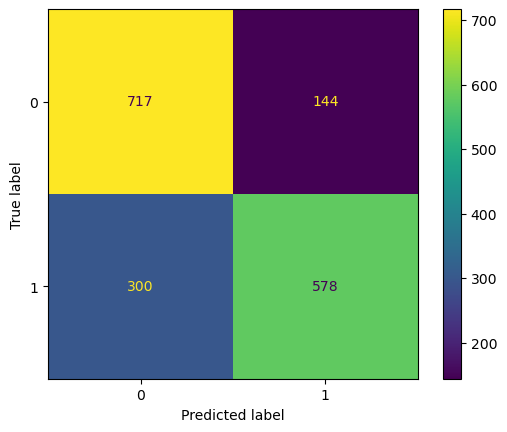

In [97]:
plot_matrix(rf_cv_acc.best_estimator_, y_val, rf_cv_acc.best_estimator_.predict(X_val))

## XGBoost Classifier 

In [82]:
clf_xgb = XGBClassifier(objective="binary:logistic", random_state=42)

cv_params = {
    "max_depth": [3, 6, 9, 12],
    "min_child_weight": [3, 5, 7, 9],
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [100, 300, 500]
}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(clf_xgb, cv_params, scoring=scoring, cv=5, refit="accuracy")

In [83]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 55min 48s, sys: 4min 49s, total: 1h 38s
Wall time: 6min 20s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 6, 9, 12],
                         'min_child_weight': [3, 5, 7, 9],
                         'n_estimators': [100, 300, 500]},
             refit='accuracy',
             scoring={'accuracy', 'recall', 'precision', 'f1'})

In [84]:
xgb_cv.best_score_

0.7515106879270128

In [85]:
xgb_table_acc = make_results("XGBoost Classifier", xgb_cv, "accuracy")
xgb_table_acc

,Model,Precision,Recall,F1,Accuracy
0,XGBoost Classifier,0.818043,0.651143,0.724945,0.751511


In [86]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 500}

In [87]:
xgb_score_acc = get_scores("XGBoost Classifier", xgb_cv, X_val, y_val)
xgb_score_acc

,model,AUC,precision,recall,f1,accuracy
0,XGBoost Classifier,0.748,0.801,0.664,0.726,0.747


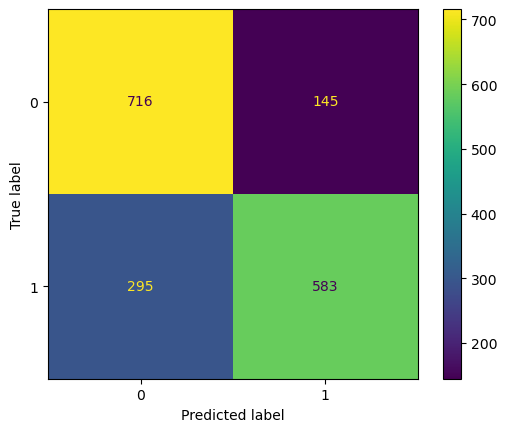

In [88]:
plot_matrix(xgb_cv.best_estimator_, y_val, xgb_cv.best_estimator_.predict(X_val))

In [98]:
table_score = pd.concat([xgb_score_acc, rf_score_acc, log_reg_table])
table_score

,model,AUC,precision,recall,f1,accuracy
0,XGBoost Classifier,0.748,0.801,0.664,0.726,0.747
0,Random Forest Classifier accuracy,0.746,0.801,0.658,0.722,0.745
0,Logistic regression,0.741,0.776,0.682,0.726,0.740


We see that two last model present almost the same result and slightly better than Logistic regression model. Let's look at the feature importance in this prediction

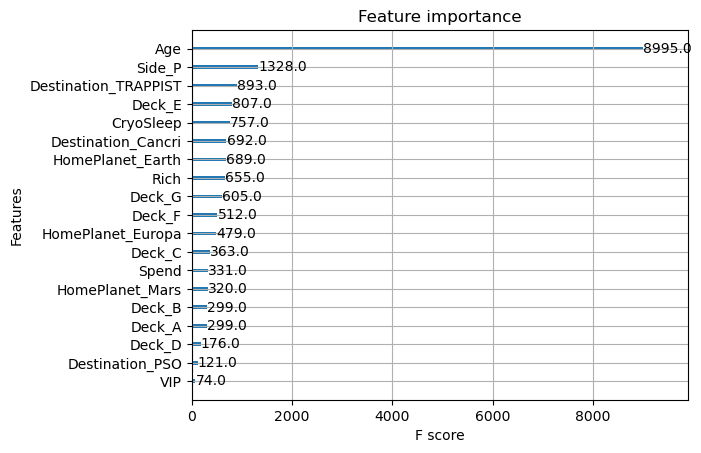

In [100]:
plot_importance(xgb_cv.best_estimator_)
plt.show()

In the next iteration let's try to drop missing value from training set and replace them only in test set.